### Install Required Packages

We would be running `Stable Diffusion 2` so enable `GPU` under `View Resources > Change runtime type`

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-4c0a0f0b-aa00-8843-48ce-7e620b92a7a2)


In [ ]:
# %%capture
!pip install accelerate
!pip install git+https://github.com/RishiDarkDevil/TITAN.git
!pip install git+https://github.com/RishiDarkDevil/daam-i2i.git

### Import Necessary Libraries

We will load the necessary libraries required for generating DAAM outputs for input prompts.

In [4]:
# General
import requests
from io import BytesIO

# Plotting
from matplotlib import pyplot as plt

# Data Handling
import numpy as np

# Image Processing
import cv2
from PIL import Image

# Image Generation
from diffusers import StableDiffusionPipeline

# Heatmap generation
import daam
import daami2i

# Model
import torch

# annotations
import titan

### Load Model

In [5]:
DEVICE = 'cuda' # device

Now, let's load the `stabilityai/stable-diffusion-2-base` diffusion model.

In [7]:
model = StableDiffusionPipeline.from_pretrained('stabilityai/stable-diffusion-2-base')
model = model.to(DEVICE) # Set it to something else if needed, make sure DAAM supports that

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

### DAAM Image Attention

In [8]:
prompt = ['People buying shirts from a roadside shop.']
objects = ['People', 'shirts', 'shop']

In [9]:
# processed_prompt = titan.PromptHandler().clean_prompt(prompt)

In [10]:
# processed_prompt

In [11]:
with daam.trace(model) as daam_trc:
  with daami2i.trace(model) as daami2i_trc:
    output_image = model(prompt=prompt).images[0]
    image_global_heat_map = daami2i_trc
    word_global_heat_map = daam_trc

  0%|          | 0/51 [00:00<?, ?it/s]

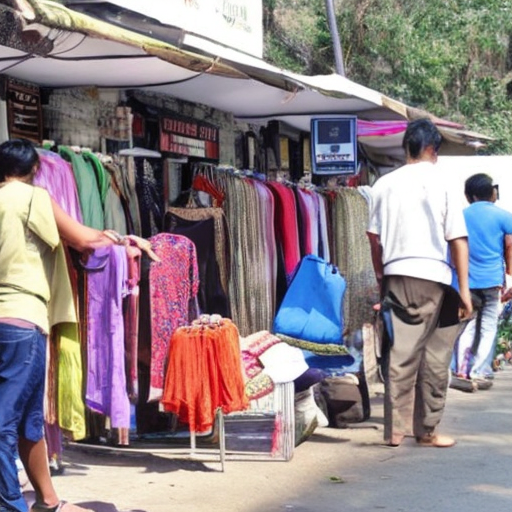

In [12]:
output_image

### Visualize Heatmaps

In [13]:
# Image2Image Attention Heatmap Aggregation for 1st Layer of UNet
image_global_heat_map = image_global_heat_map.compute_global_heat_map([1], None, None)
# Text2Image Attention Heatmap Aggregation for all Layers of UNet
word_global_heat_map = word_global_heat_map.compute_global_heat_map(None, None, None)

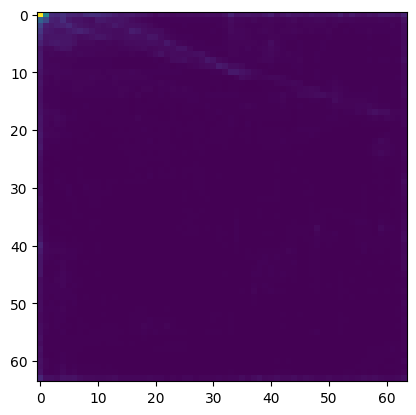

In [14]:
plt.imshow(image_global_heat_map.compute_pixel_heat_map(0).heatmap)

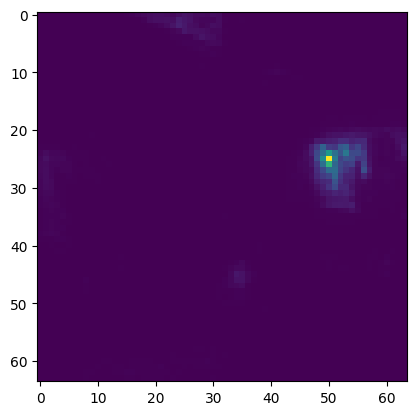

In [47]:
plt.imshow(image_global_heat_map.compute_pixel_heat_map(25*64+50).heatmap)

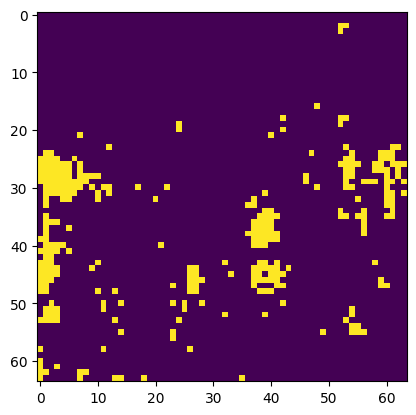

In [63]:
word_heatmap = word_global_heat_map.compute_word_heat_map(objects[0]).heatmap
# Text Guided TxtAttn Only
plt.imshow(word_heatmap.cpu().numpy() > 0.21)
plt.show()

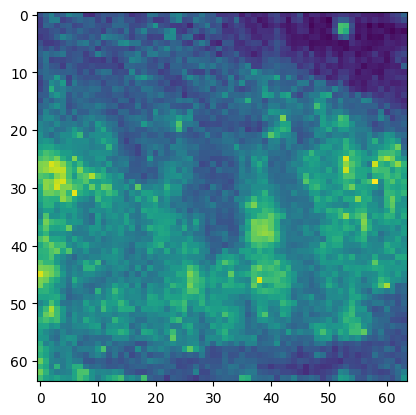

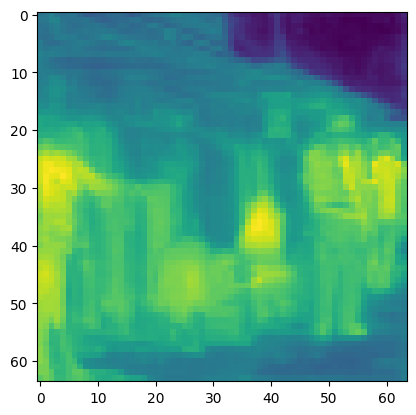

In [53]:
word_heatmap = word_global_heat_map.compute_word_heat_map(objects[0]).heatmap
# Text Guided TxtAttn Only
plt.imshow(word_heatmap.cpu().numpy())
plt.show()
# Text Guided ImgAttn Fused
plt.imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap).heatmap)
plt.show()

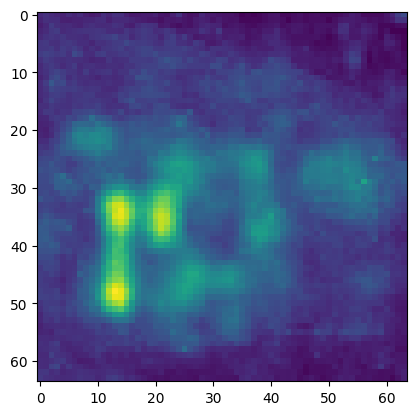

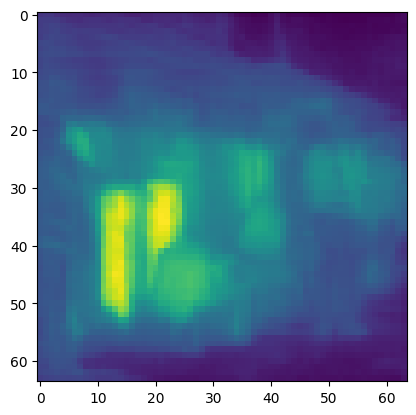

In [20]:
word_heatmap = word_global_heat_map.compute_word_heat_map(objects[1]).heatmap
# Text Guided TxtAttn Only
plt.imshow(word_heatmap.cpu().numpy())
plt.show()
# Text Guided ImgAttn Fused
plt.imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap).heatmap)
plt.show()

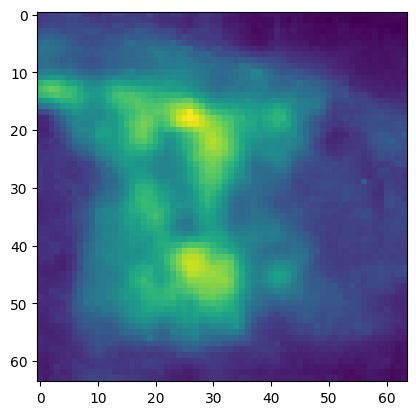

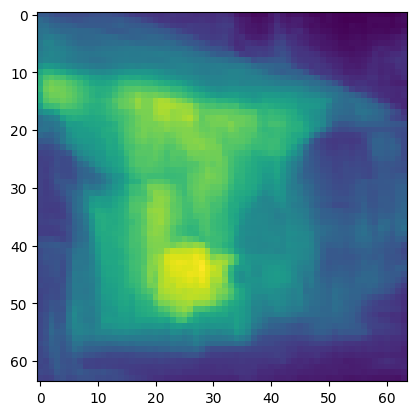

In [21]:
word_heatmap = word_global_heat_map.compute_word_heat_map(objects[2]).heatmap
# Text Guided TxtAttn Only
plt.imshow(word_heatmap.cpu().numpy())
plt.show()
# Text Guided ImgAttn Fused
plt.imshow(image_global_heat_map.compute_guided_heat_map(word_heatmap).heatmap)
plt.show()

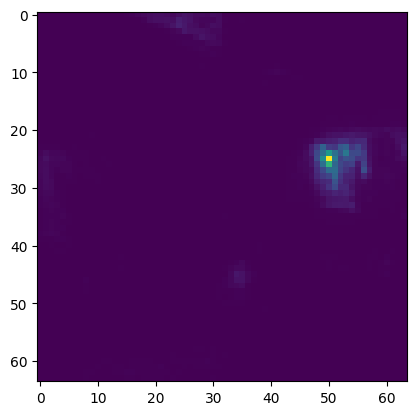

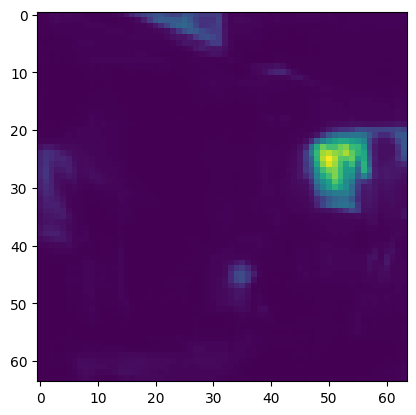

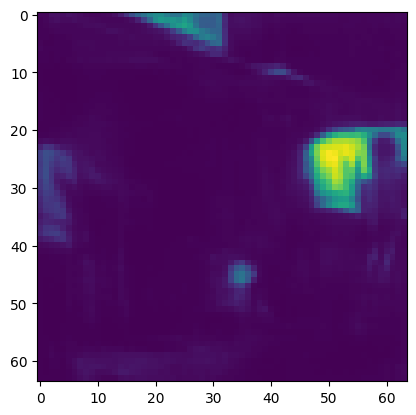

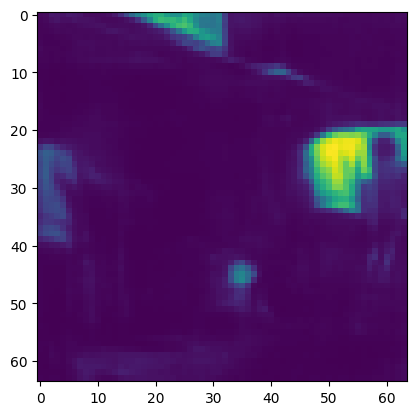

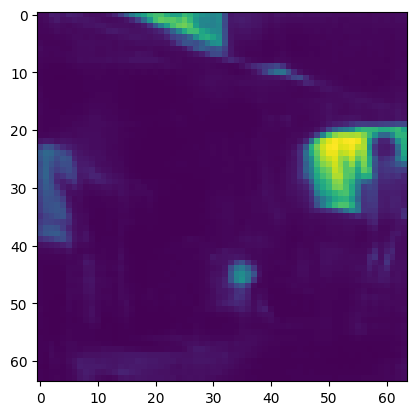

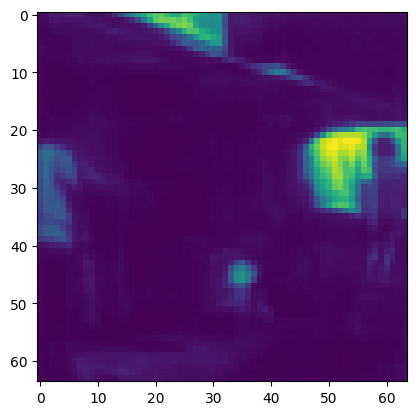

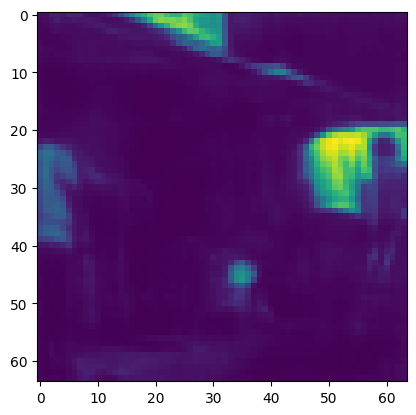

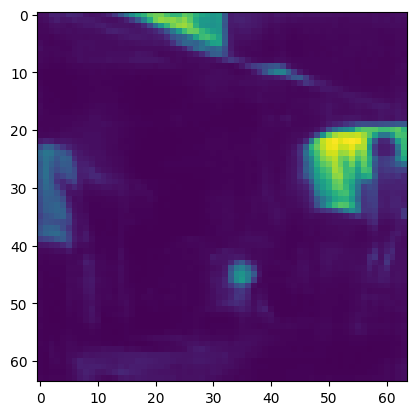

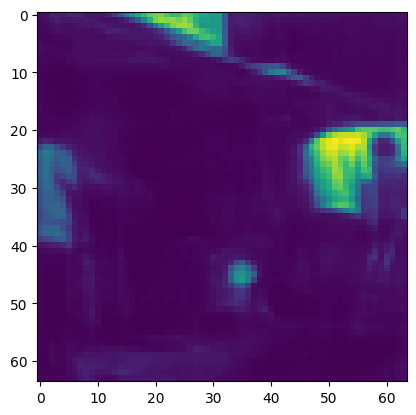

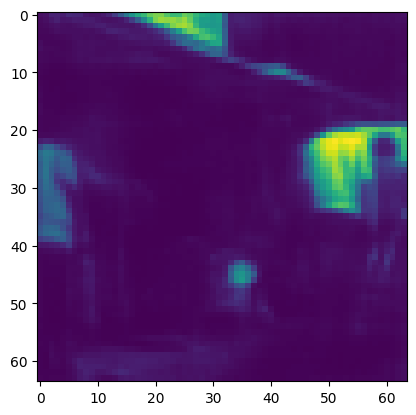

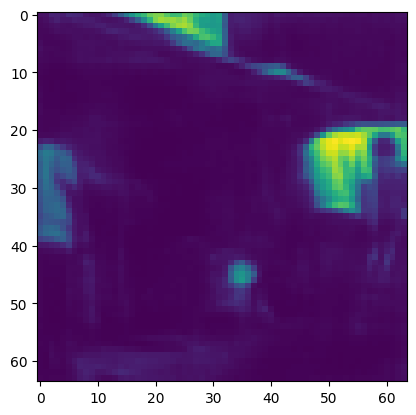

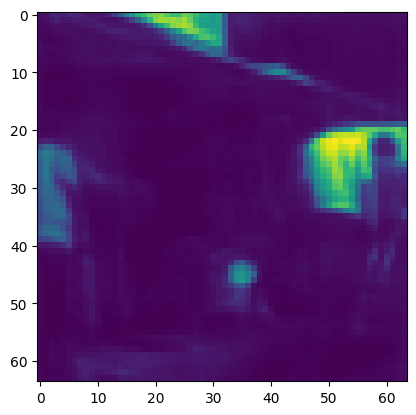

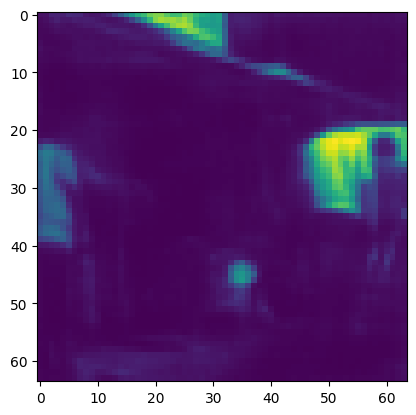

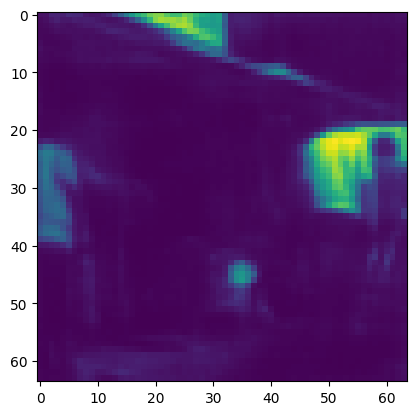

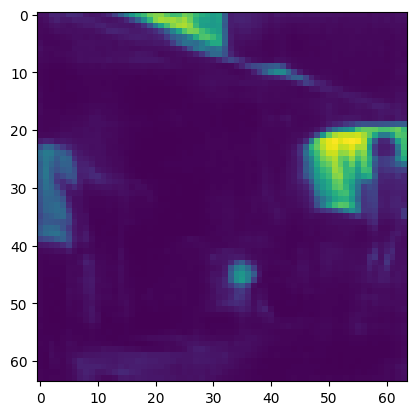

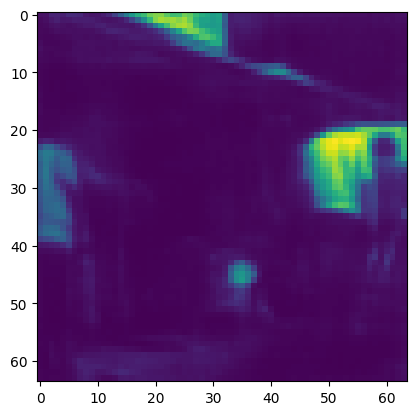

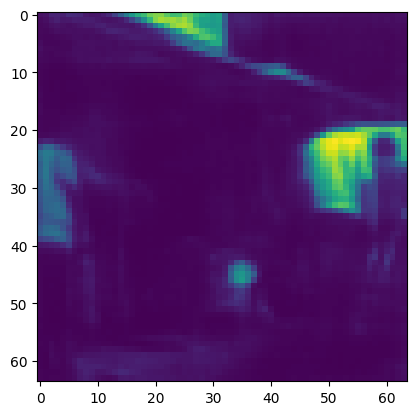

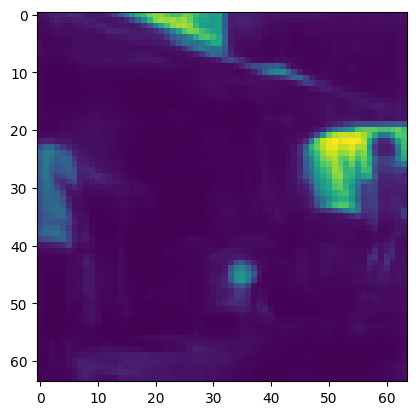

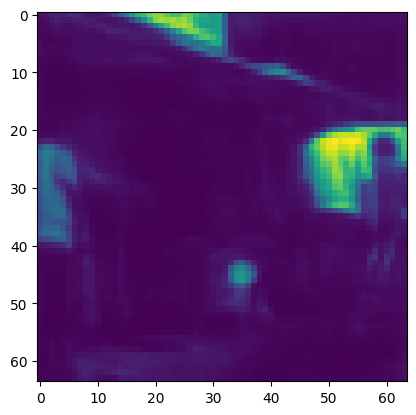

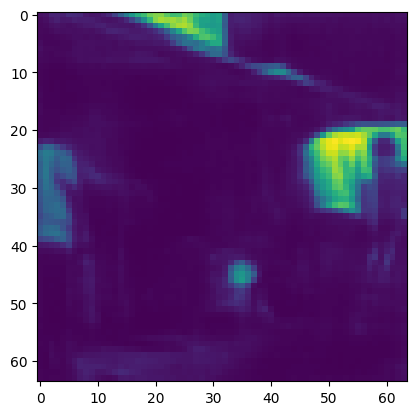

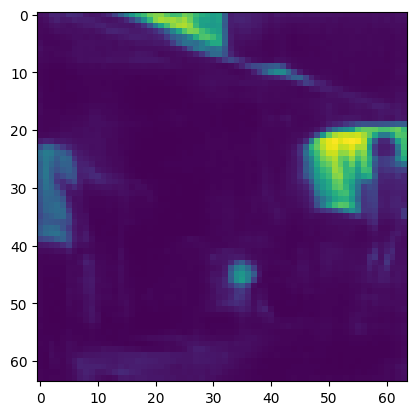

In [52]:
# Pixel Attention Diffusion Image diffusion
NUM_DIFFUSE = 20
PIXEL_ID = 25*64 + 50 # Enter Pixel ID
heatmap = image_global_heat_map.compute_pixel_diffused_heat_map(PIXEL_ID, 'thresholding', NUM_DIFFUSE, 0.02, True)

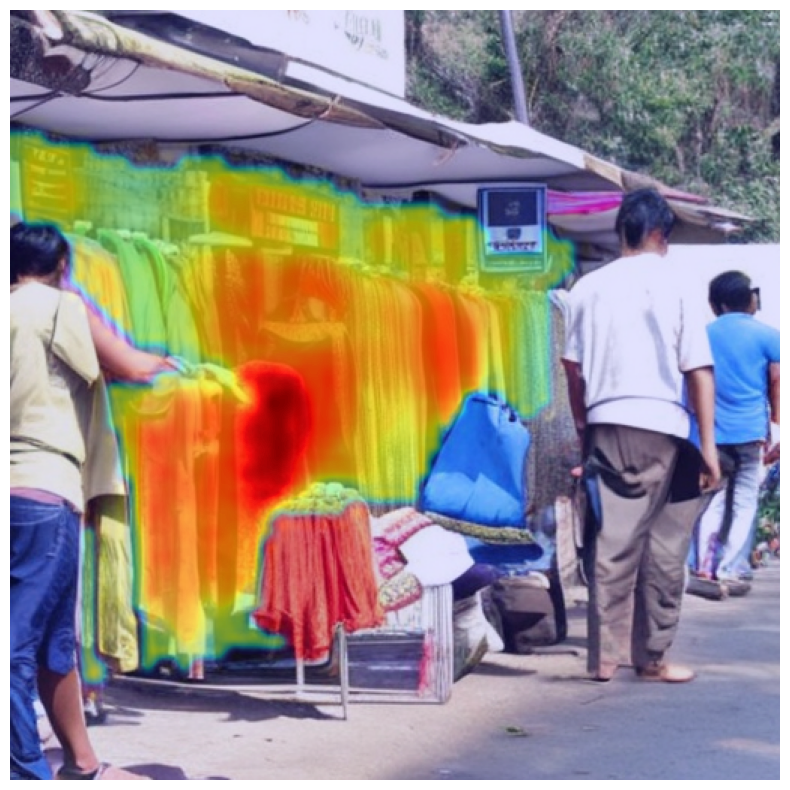

In [29]:
heatmap.plot_overlay(output_image)

In [30]:
heatmap = image_global_heat_map.compute_diffused_heat_map('thresholding', NUM_DIFFUSE, 0.015)

100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


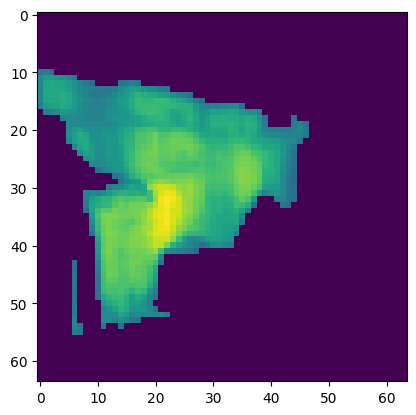

In [31]:
plt.imshow(heatmap.compute_pixel_heat_map(PIXEL_ID).heatmap)

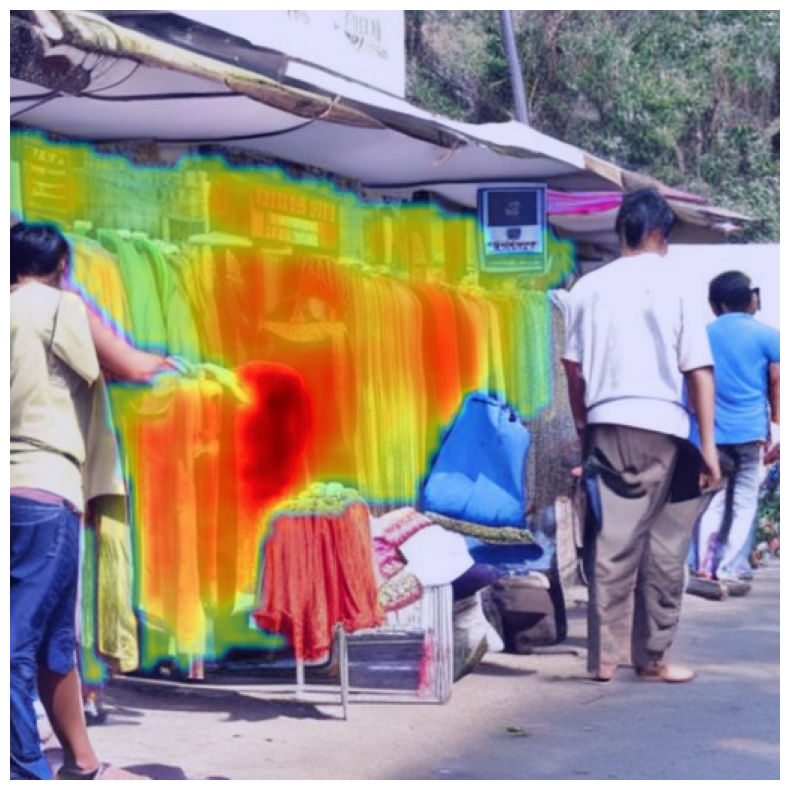

In [32]:
heatmap.compute_pixel_heat_map(PIXEL_ID).plot_overlay(output_image)

In [33]:
object_annotator = titan.ObjectAnnotator()

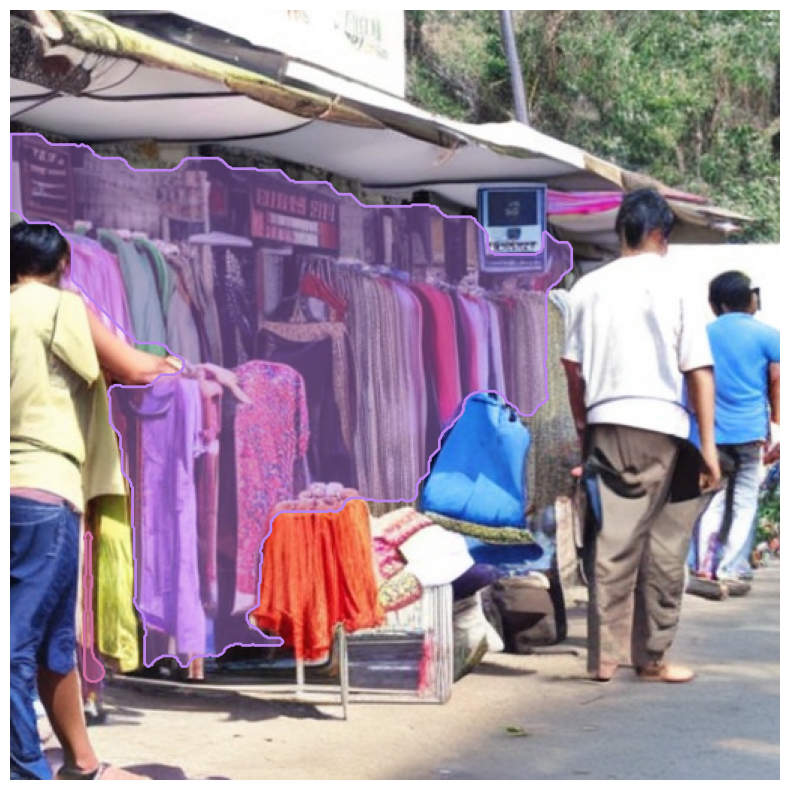

In [34]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(PIXEL_ID).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(output_image), ann, draw_bbox=False)

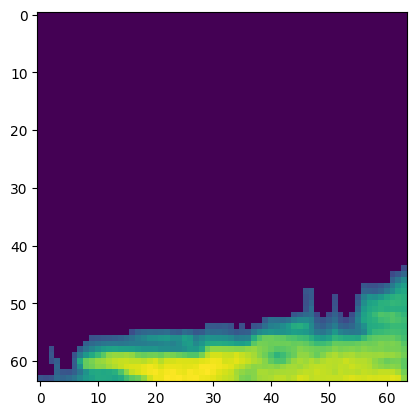

In [39]:
plt.imshow(heatmap.compute_pixel_heat_map(63*64+63).heatmap)

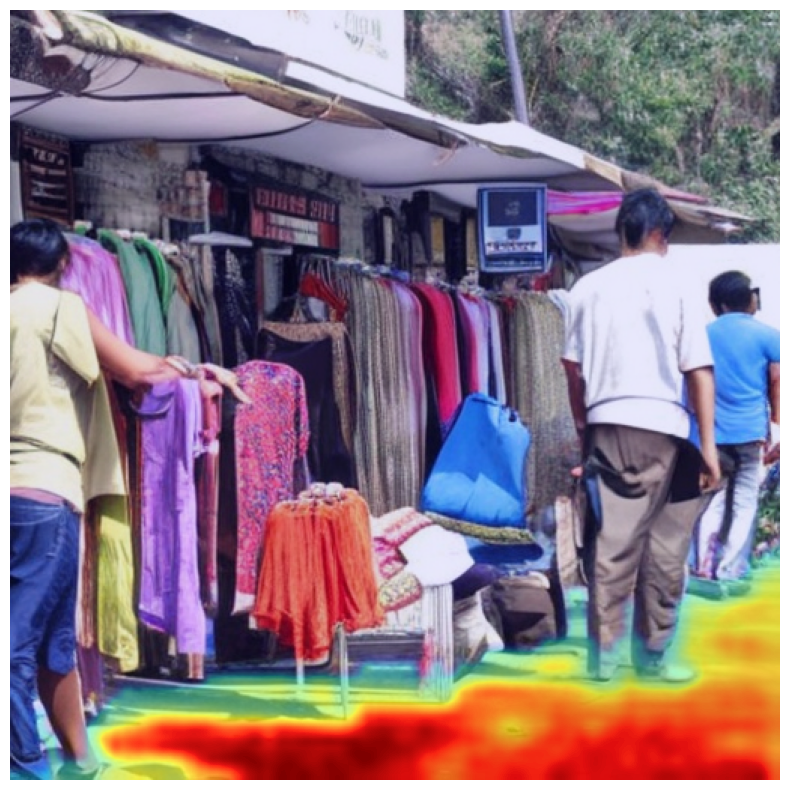

In [40]:
heatmap.compute_pixel_heat_map(63*64+63).plot_overlay(output_image)

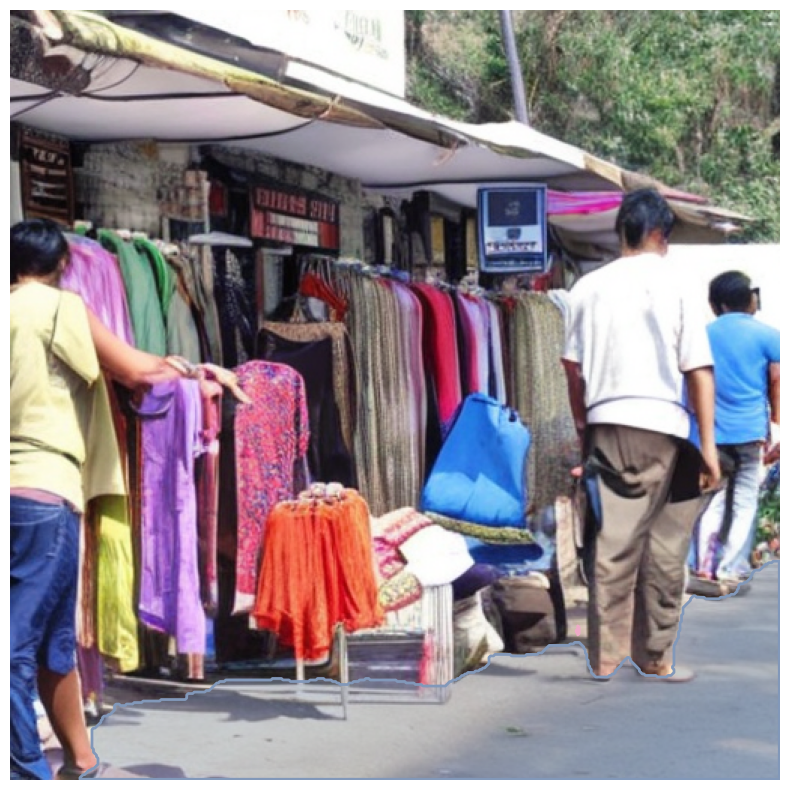

In [41]:
ann = object_annotator.wordheatmap_to_annotations(heatmap.compute_pixel_heat_map(63*64+63).expand_as(output_image).numpy(), use_nms=False, skip_small_filters=True)
object_annotator.show_annotations(np.asarray(output_image), ann, draw_bbox=False)

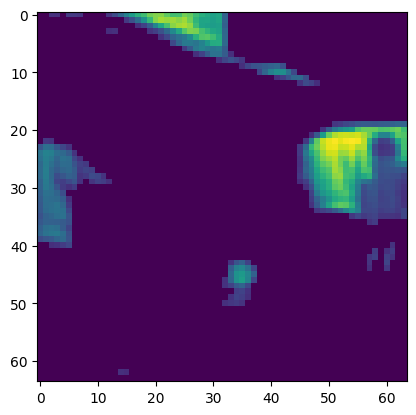

In [46]:
plt.imshow(heatmap.compute_pixel_heat_map(25*64+50).heatmap)

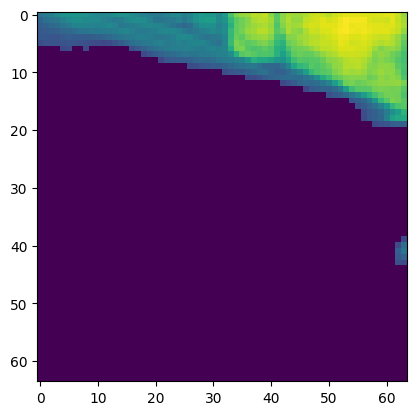

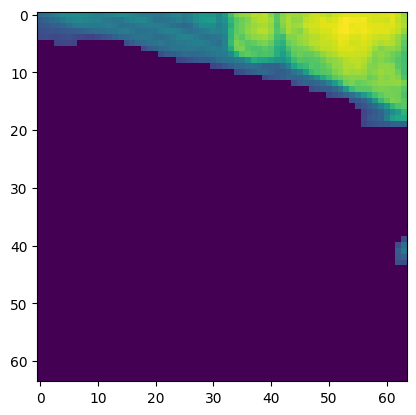

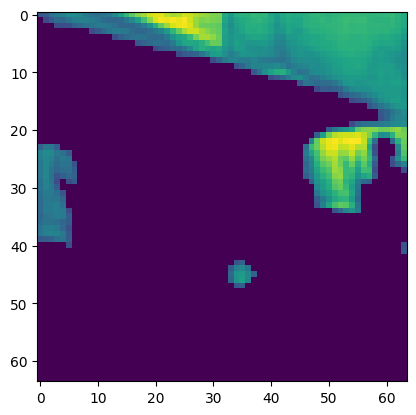

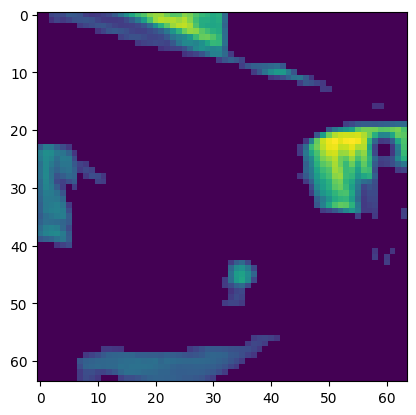

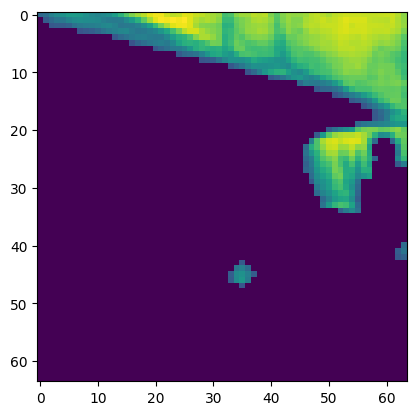

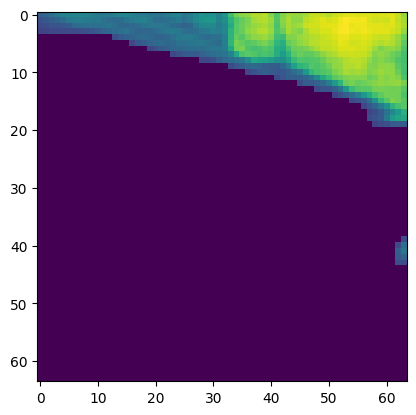

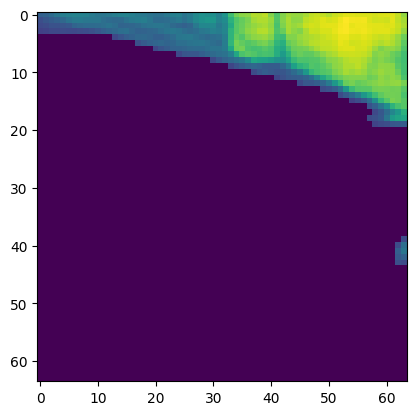

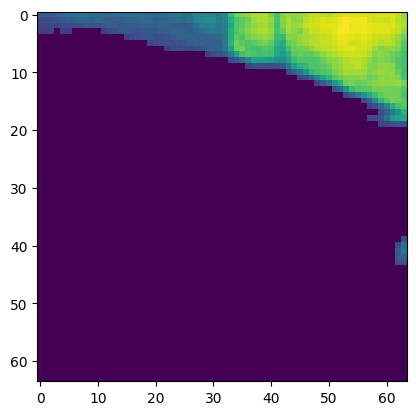

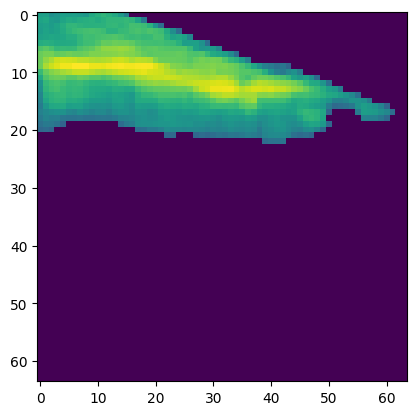

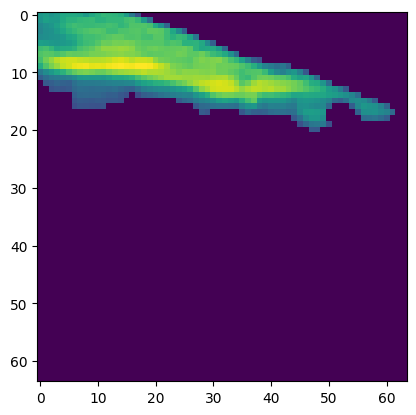

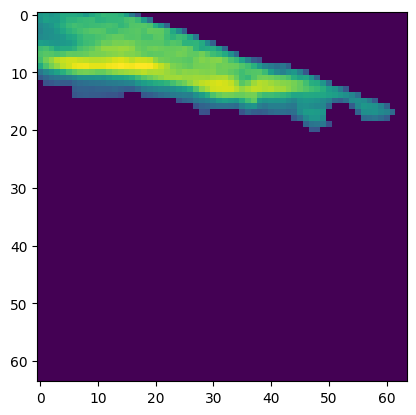

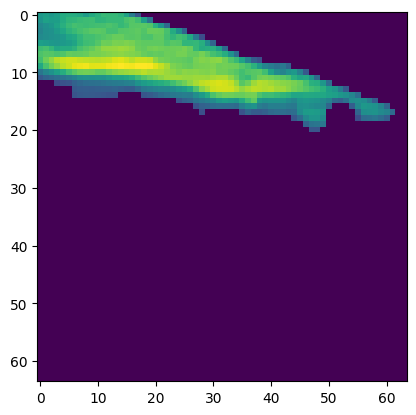

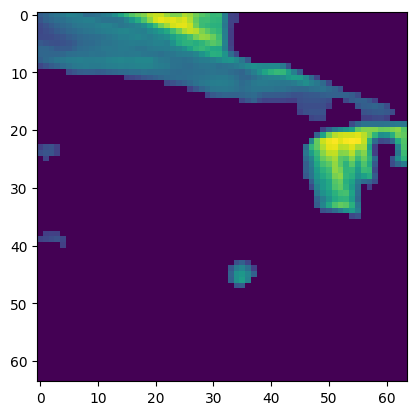

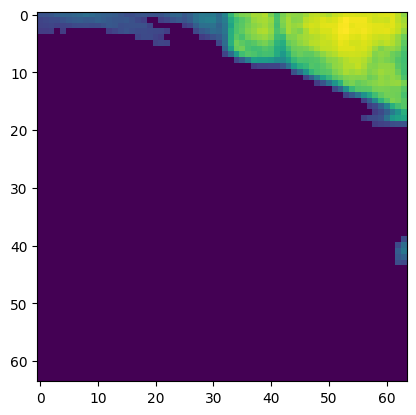

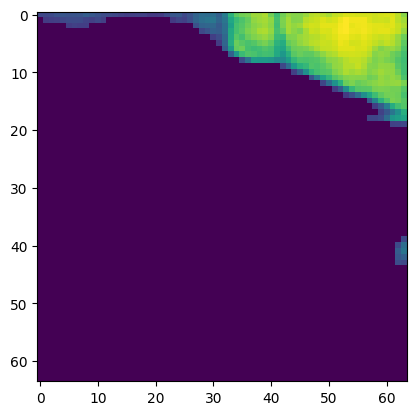

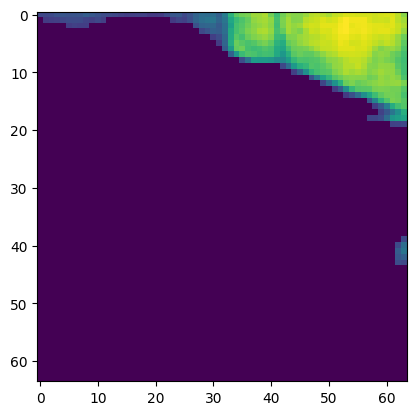

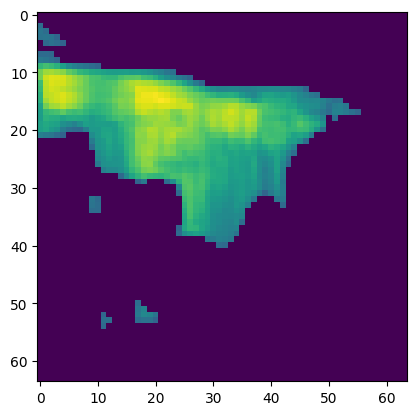

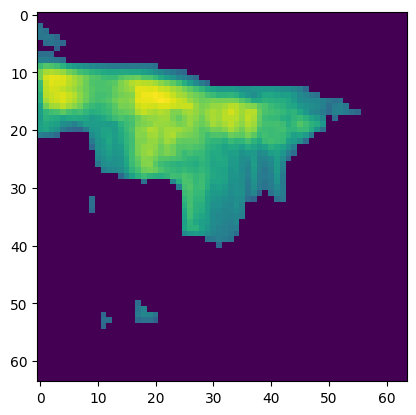

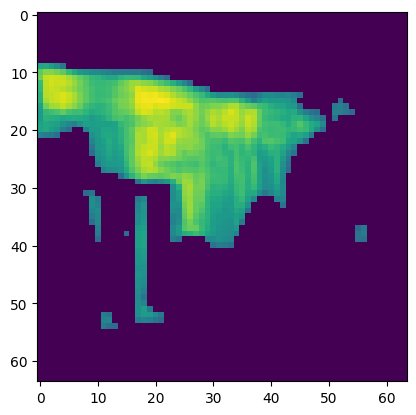

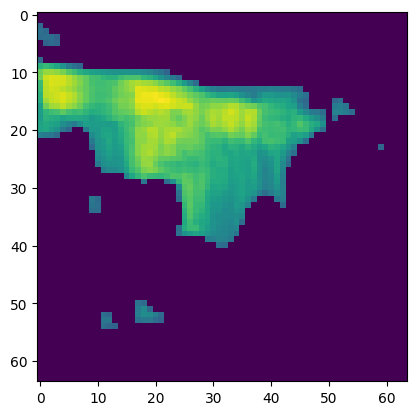

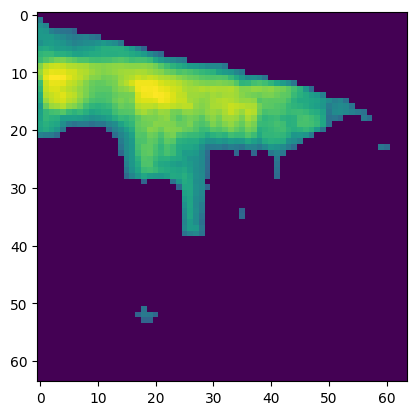

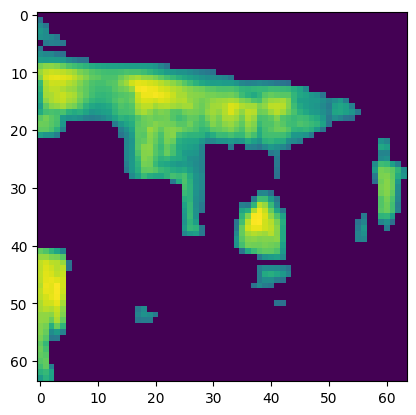

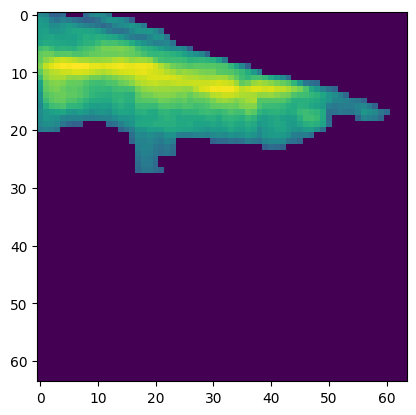

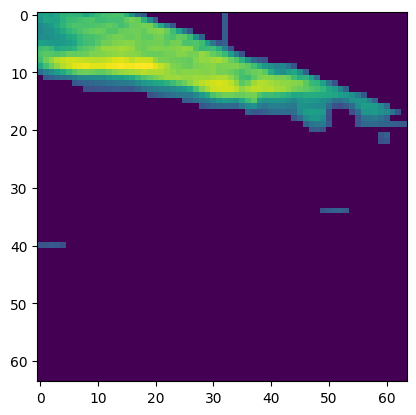

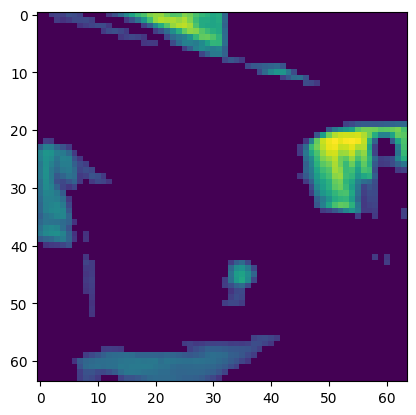

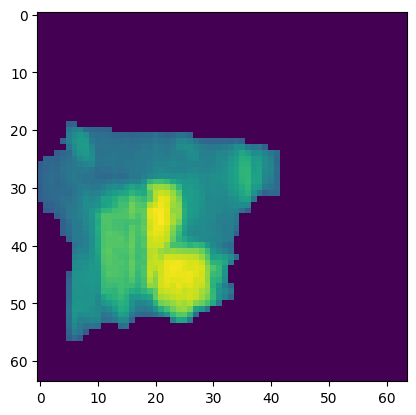

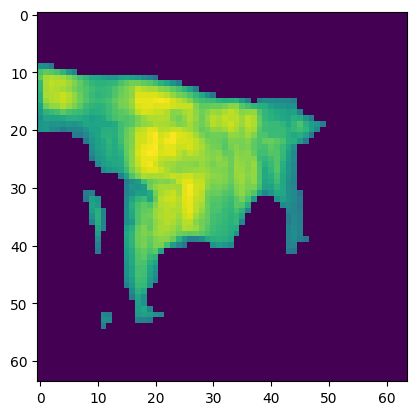

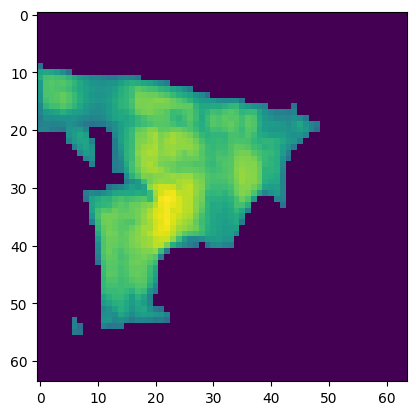

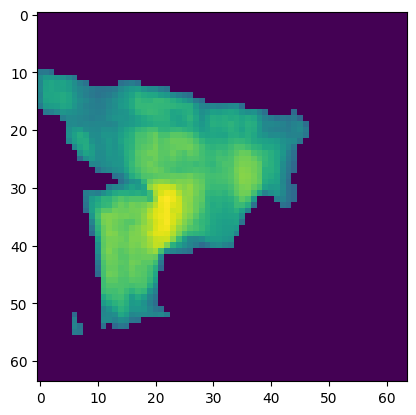

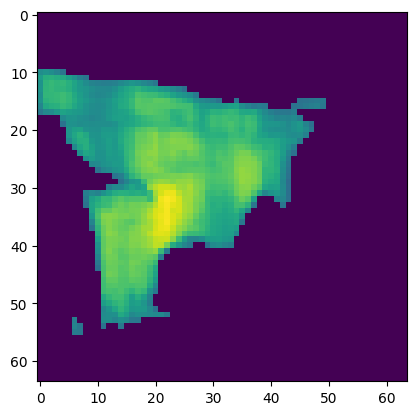

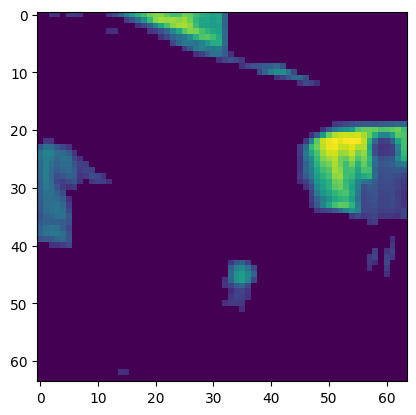

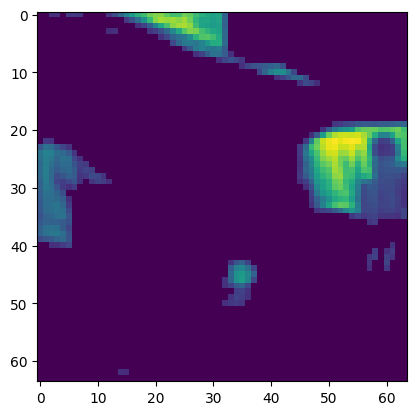

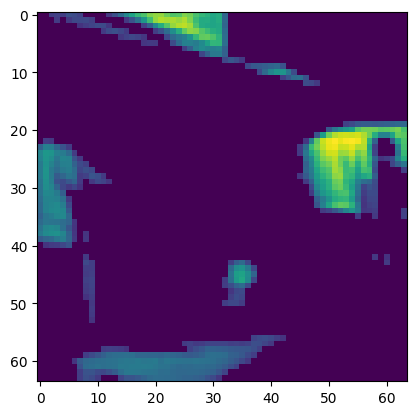

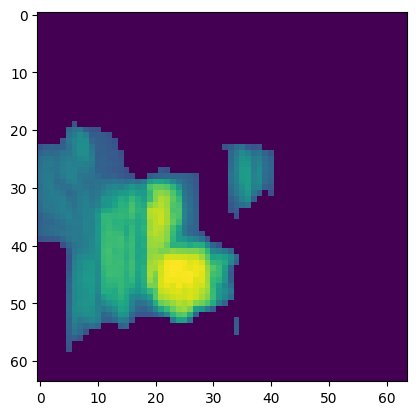

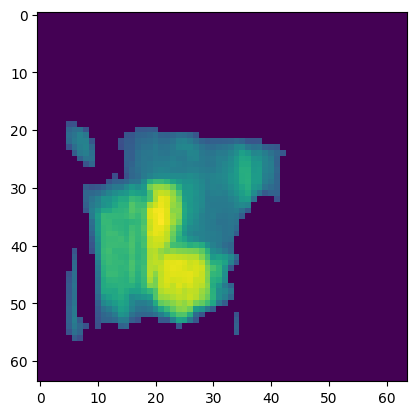

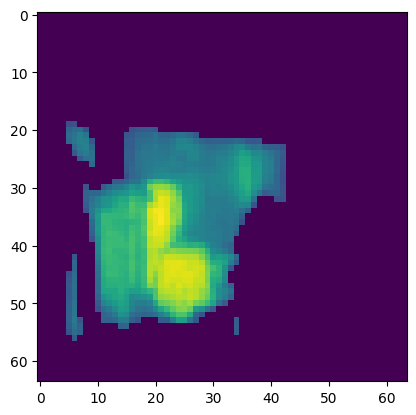

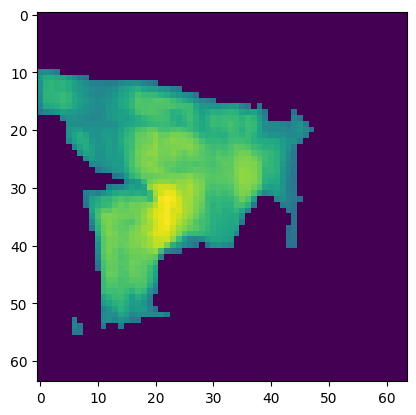

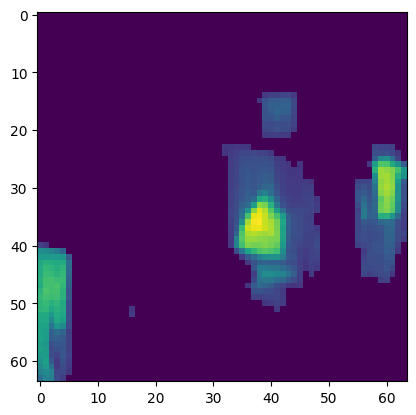

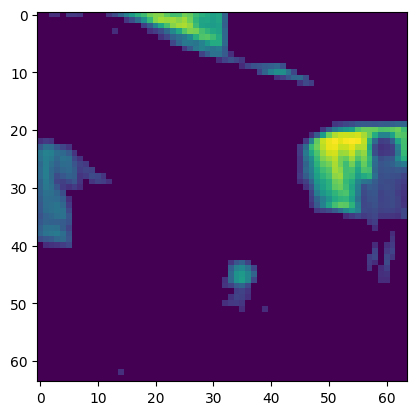

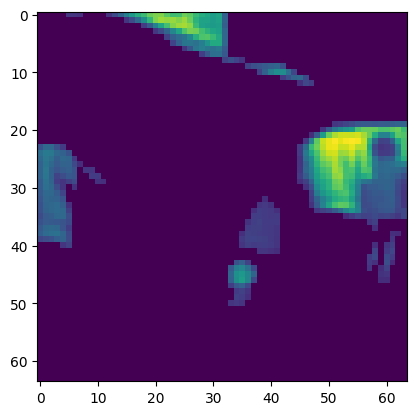

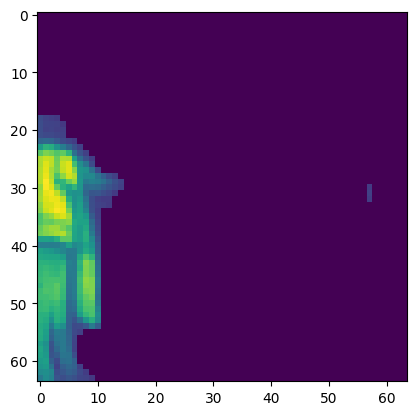

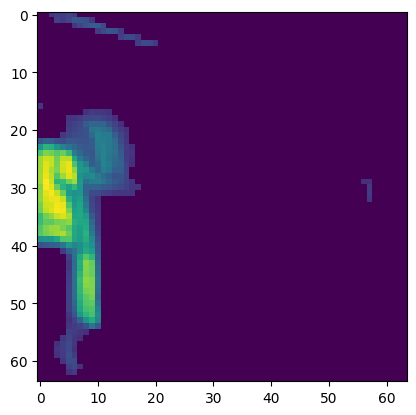

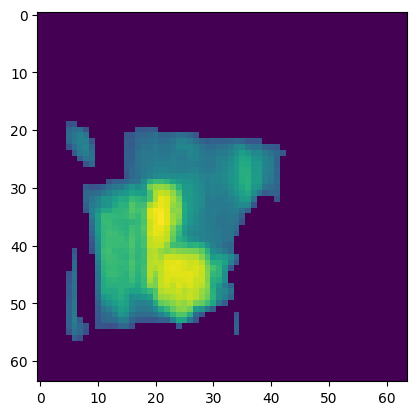

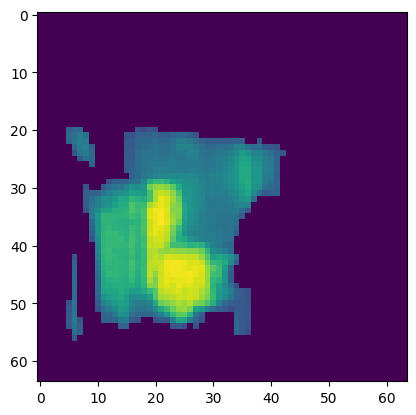

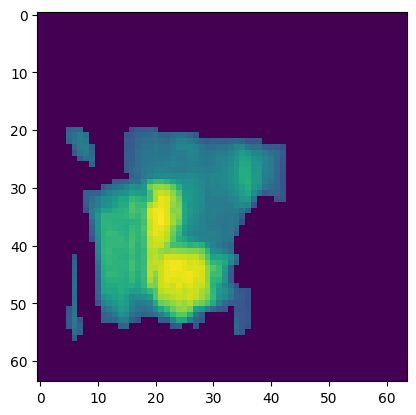

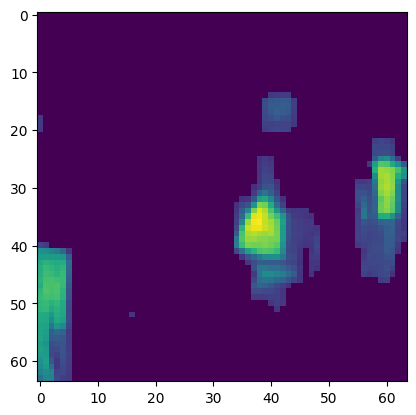

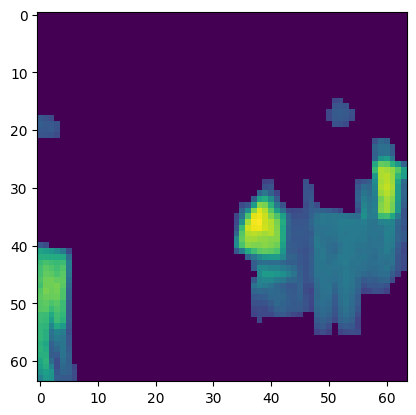

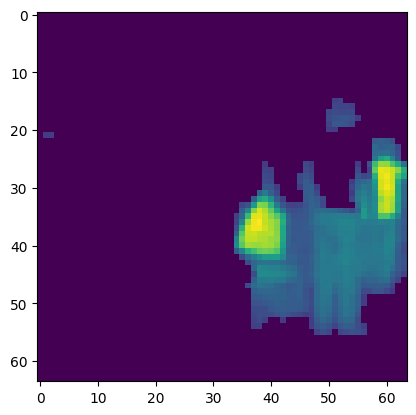

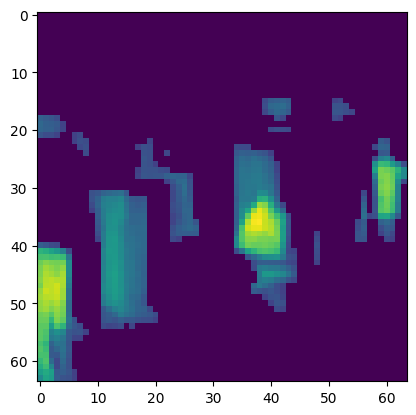

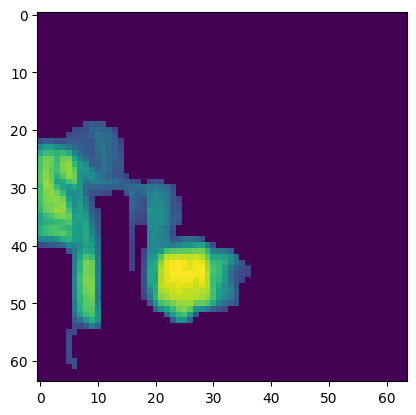

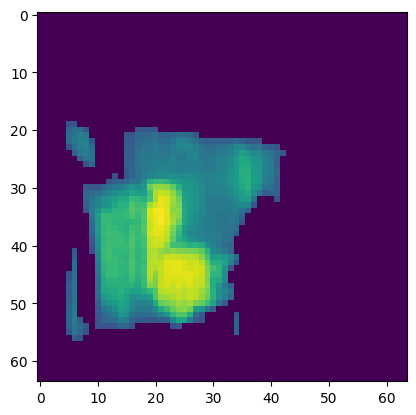

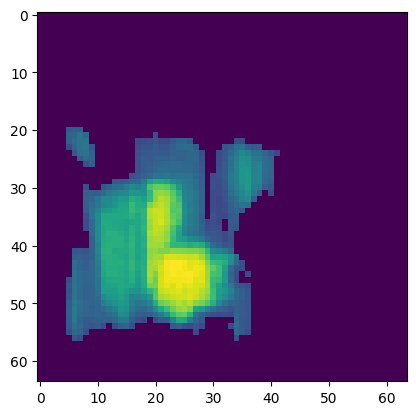

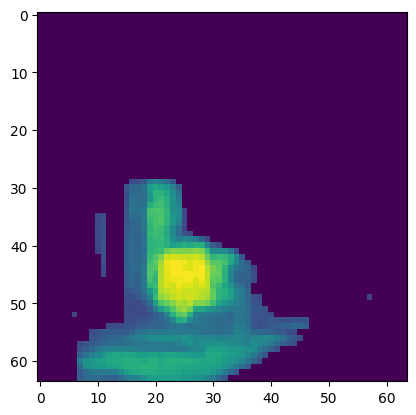

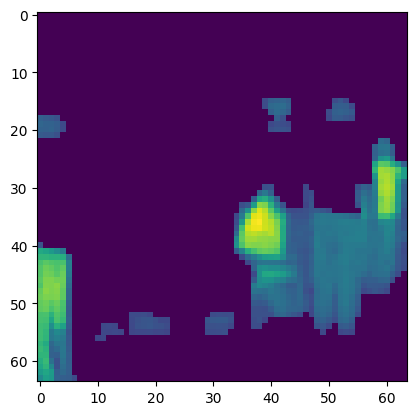

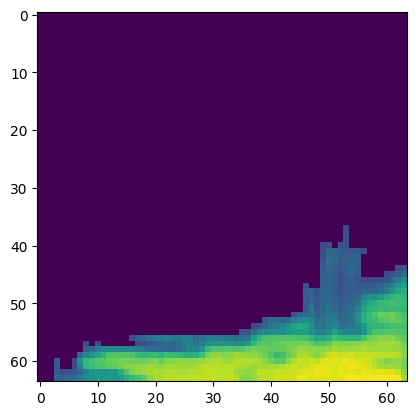

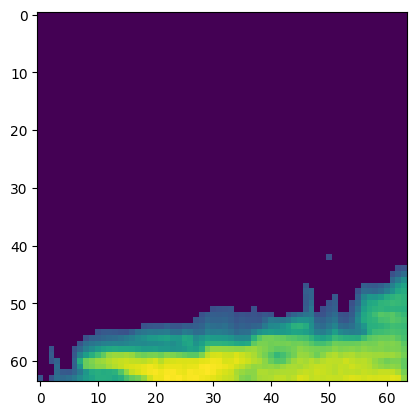

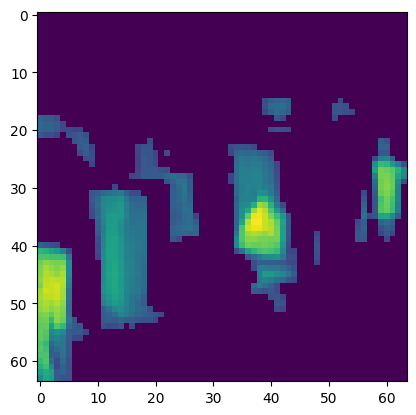

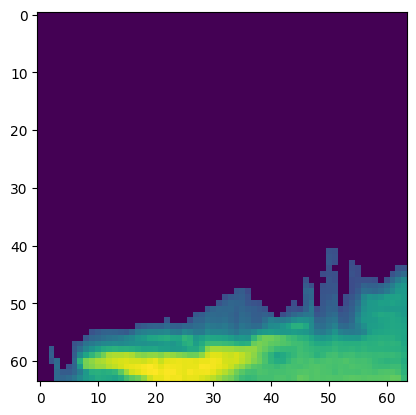

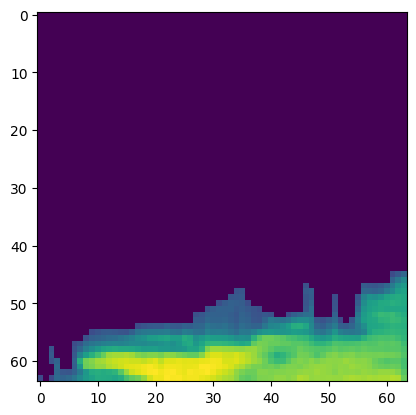

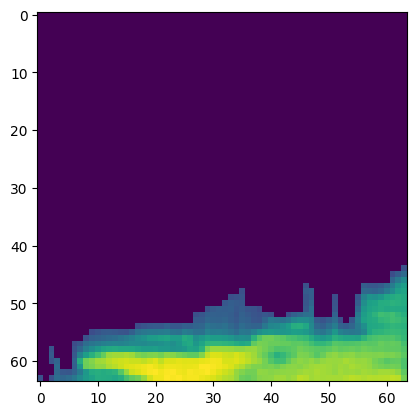

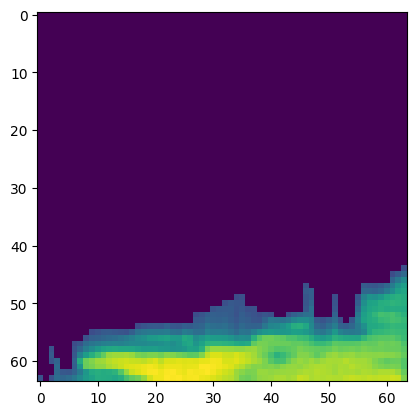

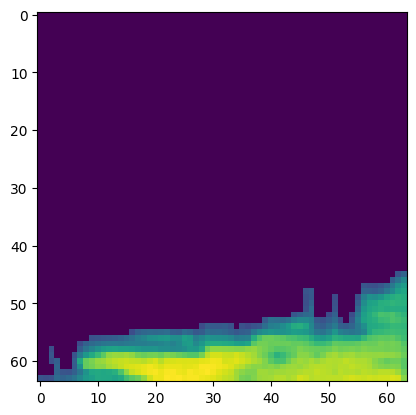

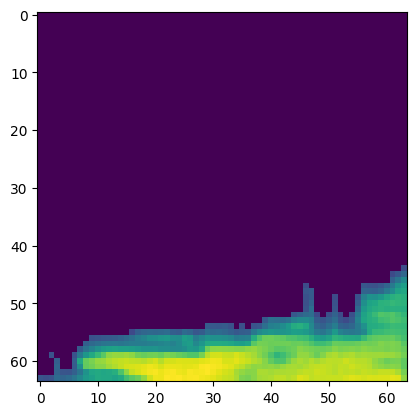

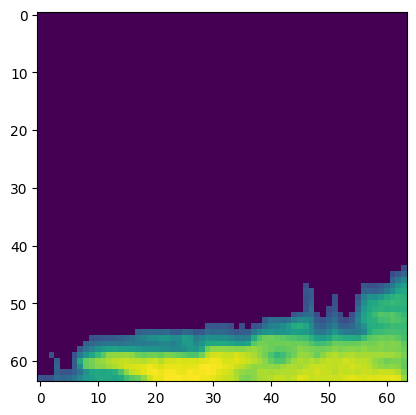

In [42]:
for i in range(0, 64, 8):
  for j in range(0, 64, 8):
    plt.imshow(heatmap.compute_pixel_heat_map(i*64+j).heatmap)
    plt.show()